<a href="https://colab.research.google.com/github/Orange314159/DataScience/blob/main/MattRobsU6proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import graphviz as gv
import matplotlib.pyplot as plt
import seaborn as sns

# The Stock Price of Nvidia

## Background

The first and most important part of this project is to consider what data sets could be useful in predicting the stock price of Nvidia. For a bit of background, Nvidia is a company that focuses on the production of GPU computer chips. A graphics processing unit or GPU is a component that is placed in computers and servers that are used to perform massvely prallel operations quickly. Currently Nvidia hardware is most often used in large data centers, super computers, and AI clusters that all need the computing power. For more background, Nvida gets its computer chips from TSMC and SK Hynix, both of which have fabs made by ASML. The competitors with Nvidia for GPUs are Intel and AMD which both also produce GPUs and buld technology for data centers.

Because there are so many connections between these companies I will focus on a much less convoluted map. For this map I have decided to include ASML as an influence on TSMC and SK-HYNIX and Nvidia. Additionally, the produe of SK-Hynix and TSMC are used in the production of computer chips for Nvidai. Additionally I will look at the competitive relationship between AMD, Intel, and Nvidia as all three produce GPUs and AI technology. Then I will also look at Amazon and Google as the data centers that use Nvidia techology. Finally to consider the general market and public sentiment I will look at the S&P 500 and VIX (Volitility Index).

In [2]:
!pip install -q "preliz[full,notebook]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.6/164.6 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.0/519.0 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 529.2/529.2 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 84.2 MB/s eta 0:00:00


In order to get the data I will access the file in my google drive.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


I can now create a data frame using this data.

In [4]:
stockData = pd.read_csv("/content/drive/MyDrive/DataScience/Project6DataSet.csv")
print(stockData.columns)

Index(['Date.0', 'Nvidia', 'Date.1', 'Amazon', 'Date.2', 'ASML', 'Date.3',
       'SK Hynix', 'Date.4', 'TSMC', 'Date.5', 'AMD', 'Date.6', 'Intel',
       'Date.7', 'S&P500', 'Date.8', 'VIX'],
      dtype='object')


The issue with this is when we consider the date format it is bad, so now I need to fix it to be better. Currently it is in the format "D/M/Y H:M:S" but I want it in ms from Linux EPOCH.

In [5]:
date_columns = [col for col in stockData.columns if col.startswith('Date.')]

for col in date_columns:
  # Convert to datetime objects
  stockData[col] = pd.to_datetime(stockData[col], format='%m/%d/%Y %H:%M:%S')
  # Convert to milliseconds from epoch
  stockData[col] = stockData[col].astype(int) // 10**6
  # Rename the column to indicate it's now epoch milliseconds
  stockData = stockData.rename(columns={col: col.replace('Date.', 'Epoch_ms_')})

# Drop all 'Epoch_ms_' columns
epoch_columns_to_drop = [col for col in stockData.columns if col.startswith('Epoch_ms_')]
stockData = stockData.drop(columns=epoch_columns_to_drop)

# print(stockData.columns)
display(stockData.head())

,Nvidia,Amazon,ASML,SK Hynix,TSMC,AMD,Intel,S&P500,VIX
0,138.31,220.22,700.42,171200.0,201.58,120.63,20.22,5868.55,17.93
1,144.47,224.19,714.36,181900.0,208.61,125.37,20.56,5942.47,16.13
2,149.43,227.61,768.51,199800.0,220.01,129.55,19.87,5975.38,16.04
3,140.14,222.11,757.58,195000.0,211.42,127.33,20.01,5909.03,17.82
4,140.11,222.13,743.98,194700.0,207.12,121.84,19.88,5918.25,17.70


This format is much better so now I can properly analyze the Nvidia stock price!!! Let's make a simple model with all of these parameters.

In [6]:
!pip install bambi -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.9/218.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 36.0 MB/s eta 0:00:00


In [7]:
import bambi as bmb

In [8]:
priors ={"Amazon" : bmb.Prior("Normal", mu=0,sigma=10), "alpha" : bmb.Prior("HalfNormal",sigma=10)}

# Drop rows with NaN values in 'Nvidia' or 'Amazon' columns
stockData_cleaned = stockData.dropna(subset=['Nvidia', 'Amazon'])

model_stock = bmb.Model("Nvidia ~ Amazon", stockData_cleaned, family = "negativebinomial", priors=priors)

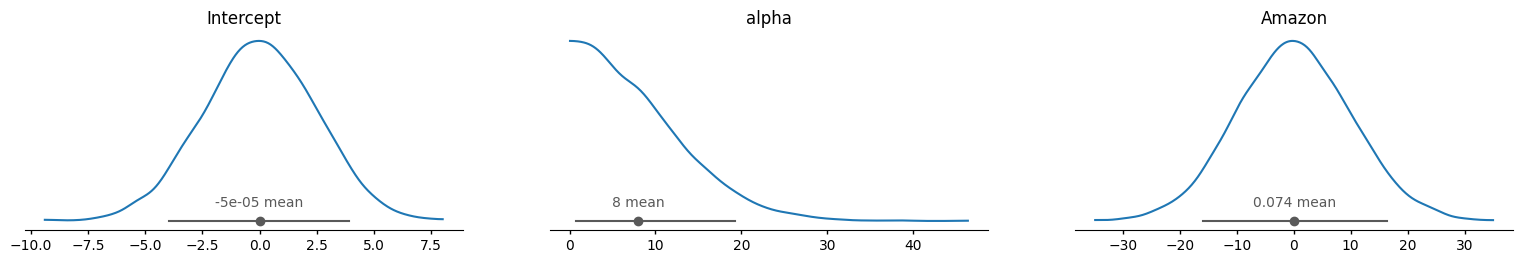

In [9]:
model_stock.build();
model_stock.plot_priors();

In [10]:
idata_stock = model_stock.fit(idata_kwargs={"log_likelihood":True})

Output()

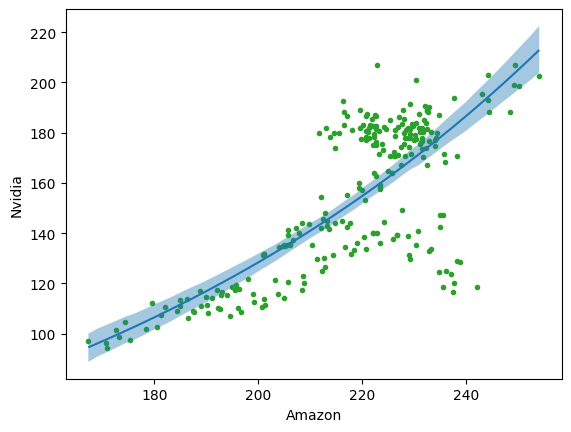

In [11]:
bmb.interpret.plot_predictions(model_stock, idata_stock, "Amazon")
plt.plot(stockData.Amazon, stockData.Nvidia, "C2.", zorder=-3)
plt.show()

Perfect! So now we can see a single variable fit of the Nvidia stock price. It is clearly not a perfect relationship, but with more data points we will get there. (not perfect, but better)

But the issue is we don't know exactly which types of plots to use so let's use a sns pair plot to determine that.

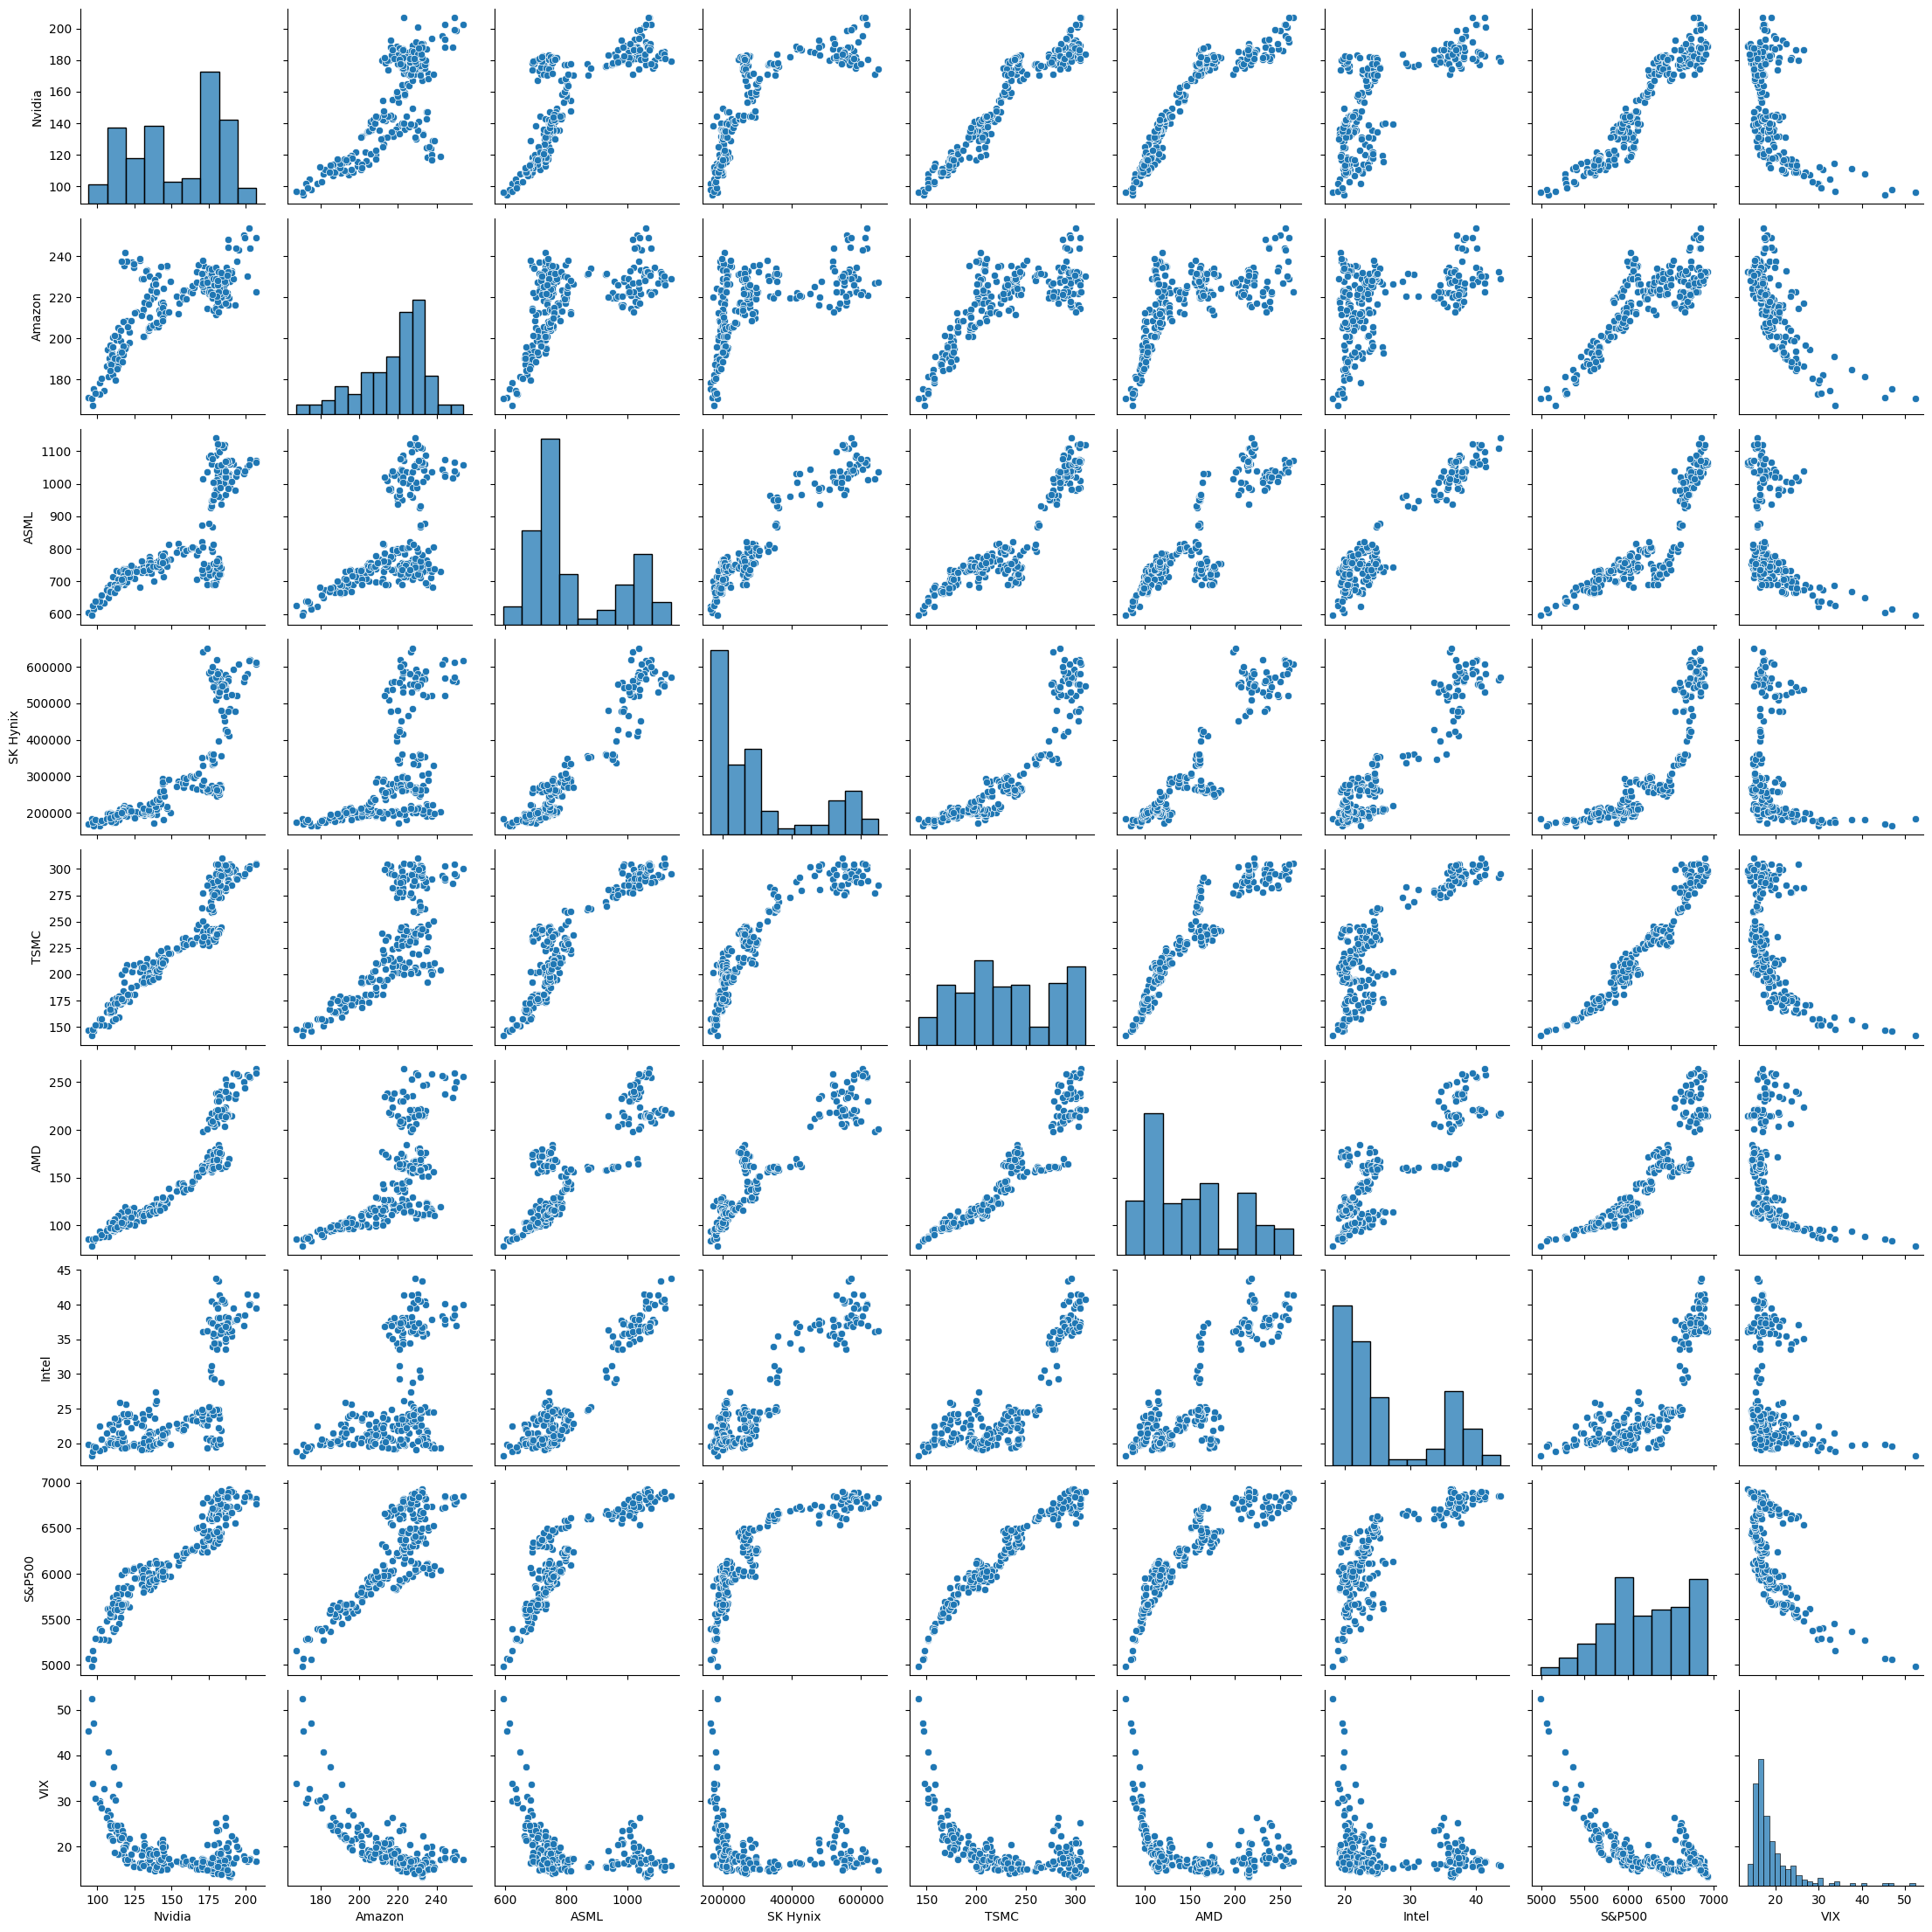

In [12]:
import seaborn as sns
sns.pairplot(stockData)
plt.show()

I am going to try and see if I can get the stock data into a form that is easier to use.

In [13]:
columns_for_unified_cleaning = ['Nvidia', 'Amazon', 'AMD', 'ASML', 'SK Hynix', 'Intel', 'TSMC']
stockData_unified_cleaned = stockData.dropna(subset=columns_for_unified_cleaning)



In [14]:
priors_ama ={"Amazon" : bmb.Prior("Normal", mu=0,sigma=10),
         "alpha" : bmb.Prior("HalfNormal",sigma=10)}

model_stock_ama = bmb.Model("Nvidia ~ Amazon", stockData_unified_cleaned, family = "negativebinomial", priors=priors_ama)
model_stock_ama.build()
idata_stock_ama = model_stock_ama.fit(idata_kwargs={"log_likelihood":True})

Output()

In [15]:
priors_asm ={"ASML" : bmb.Prior("Normal", mu=0,sigma=10),
         "alpha" : bmb.Prior("HalfNormal",sigma=10)}

model_stock_asm = bmb.Model("Nvidia ~ ASML", stockData_unified_cleaned, family = "gaussian", priors=priors_asm)
model_stock_asm.build()
idata_stock_asm = model_stock_asm.fit(idata_kwargs={"log_likelihood":True})

Output()

In [16]:
priors_all = {"Amazon" : bmb.Prior("Normal", mu=0,sigma=10),
         "AMD" : bmb.Prior("Normal", mu=0,sigma=10),
         "ASML" : bmb.Prior("Normal", mu=0,sigma=10),
         "SK Hynix" : bmb.Prior("Normal", mu=0,sigma=10),
         "Intel" : bmb.Prior("Normal", mu=0,sigma=10),
         "TSMC" : bmb.Prior("Normal", mu=0,sigma=10),"alpha" : bmb.Prior("HalfNormal",sigma=10)}

model_stock_all = bmb.Model("Nvidia ~ Amazon + AMD + ASML + `SK Hynix` + Intel + TSMC", stockData_unified_cleaned, family = "gaussian", priors=priors_all)
model_stock_all.build()
idata_stock_all = model_stock_all.fit(idata_kwargs={"log_likelihood":True})

Output()

In [17]:
priors_int ={"Intel" : bmb.Prior("Normal", mu=0,sigma=10),
         "alpha" : bmb.Prior("HalfNormal",sigma=10)}

model_stock_int = bmb.Model("Nvidia ~ Intel", stockData_unified_cleaned, family = "gaussian", priors=priors_int)
model_stock_int.build()
idata_stock_int = model_stock_int.fit(idata_kwargs={"log_likelihood":True})

Output()

In [18]:
priors_ss1 = {
        "Amazon" : bmb.Prior("Normal", mu=0,sigma=10),
        "AMD" : bmb.Prior("Normal", mu=0,sigma=10),
        "Intel" : bmb.Prior("Normal", mu=0,sigma=10),
        "alpha" : bmb.Prior("HalfNormal",sigma=10)}

model_stock_ss1 = bmb.Model("Nvidia ~ Amazon + AMD + Intel", stockData_unified_cleaned, family = "gaussian", priors=priors_ss1)
model_stock_ss1.build()
idata_stock_ss1 = model_stock_ss1.fit(idata_kwargs={"log_likelihood":True})

Output()

In [19]:
priors_ss2 = {
         "ASML" : bmb.Prior("Normal", mu=0,sigma=10),
         "SK Hynix" : bmb.Prior("Normal", mu=0,sigma=10),
         "Intel" : bmb.Prior("Normal", mu=0,sigma=10),
         "TSMC" : bmb.Prior("Normal", mu=0,sigma=10),"alpha" : bmb.Prior("HalfNormal",sigma=10)}

model_stock_ss2 = bmb.Model("Nvidia ~ ASML + `SK Hynix` + Intel + TSMC", stockData_unified_cleaned, family = "gaussian", priors=priors_ss2)
model_stock_ss2.build()
idata_stock_ss2 = model_stock_ss2.fit(idata_kwargs={"log_likelihood":True})

Output()

Wow! It seens that the fabs are much more important than the competitors, time to look at a different subset now.

In [20]:
priors_ss3 = {
         "ASML" : bmb.Prior("Normal", mu=0,sigma=10),
         "SK Hynix" : bmb.Prior("Normal", mu=0,sigma=10),
         "TSMC" : bmb.Prior("Normal", mu=0,sigma=10),"alpha" : bmb.Prior("HalfNormal",sigma=10)}

model_stock_ss3 = bmb.Model("Nvidia ~ ASML + `SK Hynix` + TSMC", stockData_unified_cleaned, family = "gaussian", priors=priors_ss3)
model_stock_ss3.build()
idata_stock_ss3 = model_stock_ss3.fit(idata_kwargs={"log_likelihood":True})

Output()

This is kinda what I expected. Intel has had a weird year, almost failing and their stock price falling because of TSMC, then the US bailing them out by buying 10%. I think that makes sense for why it might not have been as important of a factor. Let's consider a few more options though before we are done.

In [21]:
priors_ss4 = {
         "Amazon" : bmb.Prior("Normal", mu=0,sigma=10),
         "ASML" : bmb.Prior("Normal", mu=0,sigma=10),
         "SK Hynix" : bmb.Prior("Normal", mu=0,sigma=10),
         "TSMC" : bmb.Prior("Normal", mu=0,sigma=10),"alpha" : bmb.Prior("HalfNormal",sigma=10)}

model_stock_ss4 = bmb.Model("Nvidia ~ Amazon + ASML + `SK Hynix` + TSMC", stockData_unified_cleaned, family = "gaussian", priors=priors_ss4)
model_stock_ss4.build()
idata_stock_ss4 = model_stock_ss4.fit(idata_kwargs={"log_likelihood":True})

Output()

In [22]:
# Now perform the comparison
cmp_df = az.compare({"all":idata_stock_all,
                     "amazon_only":idata_stock_ama,
                     "ASML_only":idata_stock_asm,
                     "Intel_only":idata_stock_int,
                     "non_fab":idata_stock_ss1,
                     "fab+intel":idata_stock_ss2,
                     "fab_only":idata_stock_ss3,
                     "fab+amazon": idata_stock_ss4} )

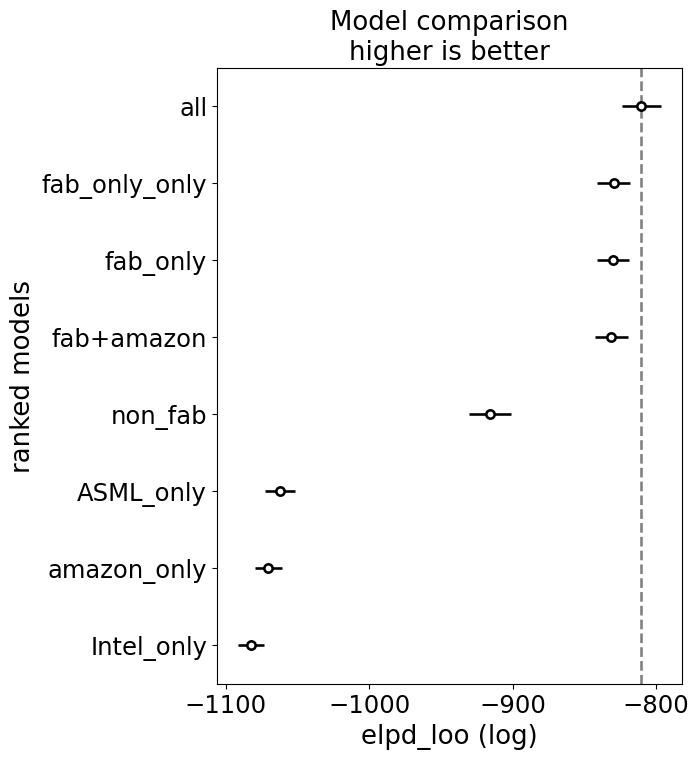

In [23]:
az.plot_compare(cmp_df);

In [24]:
from itertools import combinations

# Identify all relevant stock columns (excluding 'Nvidia', 'S&P500', 'VIX')
predictor_columns = [col for col in stockData_unified_cleaned.columns if col not in ['Nvidia', 'S&P500', 'VIX']]

# Generate all unique combinations of 4 predictor stocks
stock_combinations = list(combinations(predictor_columns, 4))

Number of predictor columns: 6
First 5 predictor columns: ['Amazon', 'ASML', 'SK Hynix', 'TSMC', 'AMD']
Number of 4-stock combinations: 15
First 5 4-stock combinations: [('Amazon', 'ASML', 'SK Hynix', 'TSMC'), ('Amazon', 'ASML', 'SK Hynix', 'AMD'), ('Amazon', 'ASML', 'SK Hynix', 'Intel'), ('Amazon', 'ASML', 'TSMC', 'AMD'), ('Amazon', 'ASML', 'TSMC', 'Intel')]


In [25]:
idata_models = {}

for i, combination in enumerate(stock_combinations):
    formatted_combination = [f"`{col}`" if ' ' in col else col for col in combination]
    formula = f"Nvidia ~ {' + '.join(formatted_combination)}"

    current_priors = {
        stock: bmb.Prior("Normal", mu=0, sigma=10)
        for stock in combination
    }
    current_priors["alpha"] = bmb.Prior("HalfNormal", sigma=10)

    model_name_key = "_" + "_".join(combination)
    print(f"Building and fitting model for: {model_name_key}")

    current_cols = ['Nvidia'] + list(combination)
    model_data_cleaned = stockData_unified_cleaned[current_cols].dropna()

    model = bmb.Model(formula, model_data_cleaned, family="gaussian", priors=current_priors)

    model.build()

    idata = model.fit(idata_kwargs={"log_likelihood": True})

    idata_models[model_name_key] = idata
    print(f"Finished model for: {model_name_key}\n")

print(f"Successfully built and fitted {len(idata_models)} models.")

Building and fitting model for: _Amazon_ASML_SK Hynix_TSMC


Output()

Finished model for: _Amazon_ASML_SK Hynix_TSMC

Building and fitting model for: _Amazon_ASML_SK Hynix_AMD


Output()

Finished model for: _Amazon_ASML_SK Hynix_AMD

Building and fitting model for: _Amazon_ASML_SK Hynix_Intel


Output()

Finished model for: _Amazon_ASML_SK Hynix_Intel

Building and fitting model for: _Amazon_ASML_TSMC_AMD


Output()

Finished model for: _Amazon_ASML_TSMC_AMD

Building and fitting model for: _Amazon_ASML_TSMC_Intel


Output()

Finished model for: _Amazon_ASML_TSMC_Intel

Building and fitting model for: _Amazon_ASML_AMD_Intel


Output()

Finished model for: _Amazon_ASML_AMD_Intel

Building and fitting model for: _Amazon_SK Hynix_TSMC_AMD


Output()

Finished model for: _Amazon_SK Hynix_TSMC_AMD

Building and fitting model for: _Amazon_SK Hynix_TSMC_Intel


Output()

Finished model for: _Amazon_SK Hynix_TSMC_Intel

Building and fitting model for: _Amazon_SK Hynix_AMD_Intel


Output()

Finished model for: _Amazon_SK Hynix_AMD_Intel

Building and fitting model for: _Amazon_TSMC_AMD_Intel


Output()

Finished model for: _Amazon_TSMC_AMD_Intel

Building and fitting model for: _ASML_SK Hynix_TSMC_AMD


Output()

Finished model for: _ASML_SK Hynix_TSMC_AMD

Building and fitting model for: _ASML_SK Hynix_TSMC_Intel


Output()

Finished model for: _ASML_SK Hynix_TSMC_Intel

Building and fitting model for: _ASML_SK Hynix_AMD_Intel


Output()

Finished model for: _ASML_SK Hynix_AMD_Intel

Building and fitting model for: _ASML_TSMC_AMD_Intel


Output()

Finished model for: _ASML_TSMC_AMD_Intel

Building and fitting model for: _SK Hynix_TSMC_AMD_Intel


Output()

Finished model for: _SK Hynix_TSMC_AMD_Intel

Successfully built and fitted 15 models.


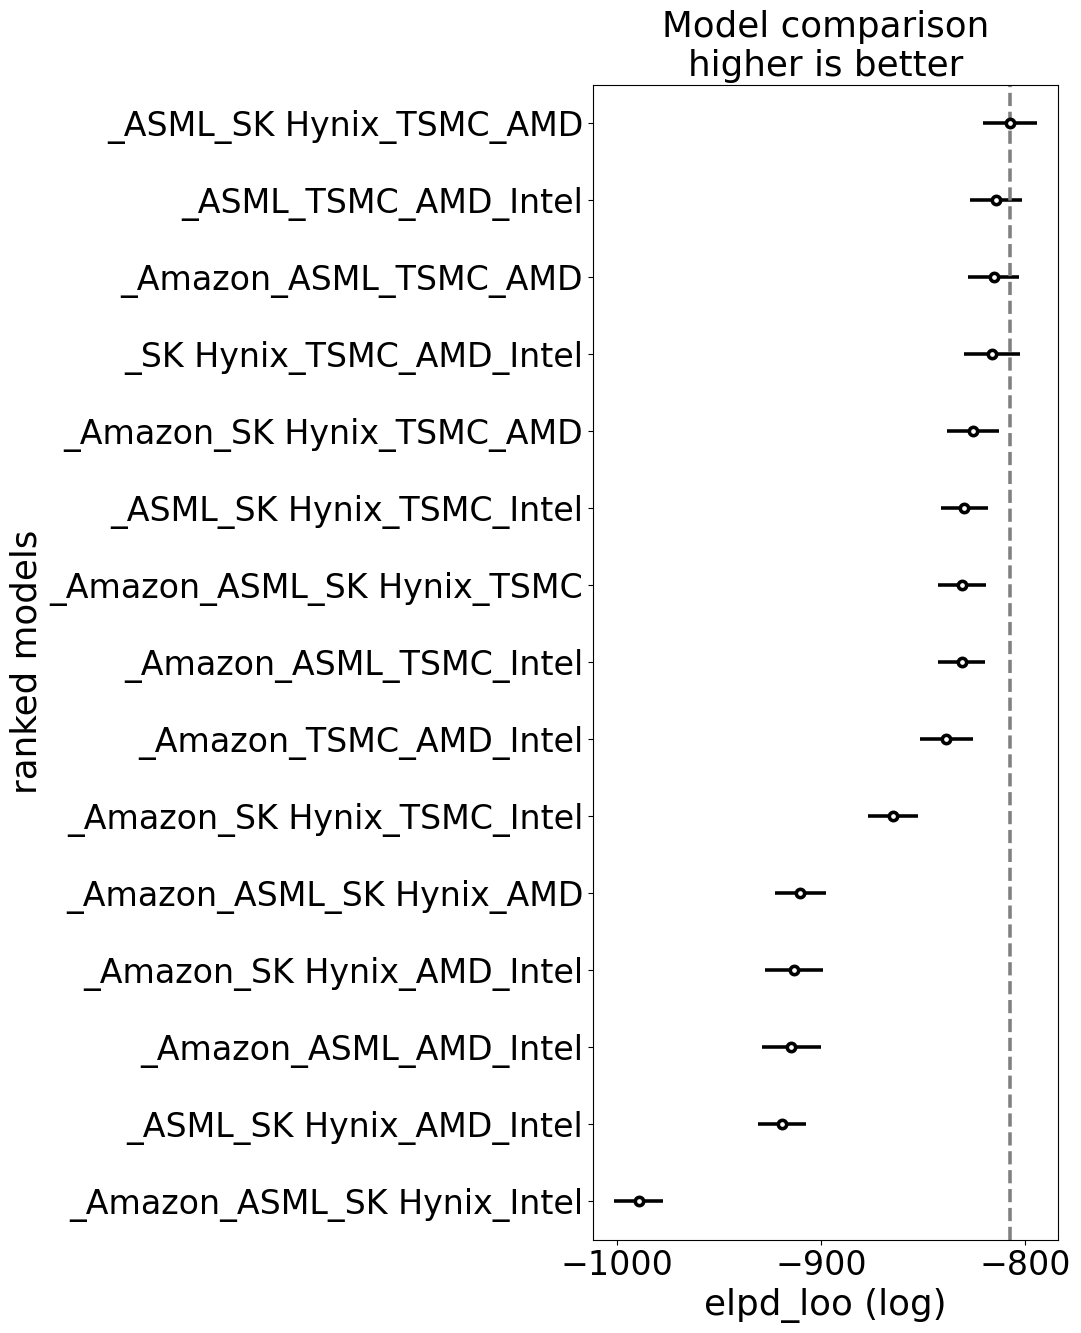

In [26]:
cmp_df_combinations = az.compare(idata_models)
az.plot_compare(cmp_df_combinations);

Let's see if 5 priors will do any better.

In [27]:
stock_combinations = list(combinations(predictor_columns, 5))

In [28]:
idata_models = {}

for i, combination in enumerate(stock_combinations):
    formatted_combination = [f"`{col}`" if ' ' in col else col for col in combination]
    formula = f"Nvidia ~ {' + '.join(formatted_combination)}"

    current_priors = {
        stock: bmb.Prior("Normal", mu=0, sigma=10)
        for stock in combination
    }
    current_priors["alpha"] = bmb.Prior("HalfNormal", sigma=10)

    model_name_key = "_" + "_".join(combination)
    print(f"Building and fitting model for: {model_name_key}")

    current_cols = ['Nvidia'] + list(combination)
    model_data_cleaned = stockData_unified_cleaned[current_cols].dropna()

    model = bmb.Model(formula, model_data_cleaned, family="gaussian", priors=current_priors)

    model.build()

    idata = model.fit(idata_kwargs={"log_likelihood": True})

    idata_models[model_name_key] = idata
    print(f"Finished model for: {model_name_key}\n")

print(f"Successfully built and fitted {len(idata_models)} models.")

Building and fitting model for: _Amazon_ASML_SK Hynix_TSMC_AMD


Output()

Finished model for: _Amazon_ASML_SK Hynix_TSMC_AMD

Building and fitting model for: _Amazon_ASML_SK Hynix_TSMC_Intel


Output()

Finished model for: _Amazon_ASML_SK Hynix_TSMC_Intel

Building and fitting model for: _Amazon_ASML_SK Hynix_AMD_Intel


Output()

Finished model for: _Amazon_ASML_SK Hynix_AMD_Intel

Building and fitting model for: _Amazon_ASML_TSMC_AMD_Intel


Output()

Finished model for: _Amazon_ASML_TSMC_AMD_Intel

Building and fitting model for: _Amazon_SK Hynix_TSMC_AMD_Intel


Output()

Finished model for: _Amazon_SK Hynix_TSMC_AMD_Intel

Building and fitting model for: _ASML_SK Hynix_TSMC_AMD_Intel


Output()

Finished model for: _ASML_SK Hynix_TSMC_AMD_Intel

Successfully built and fitted 6 models.


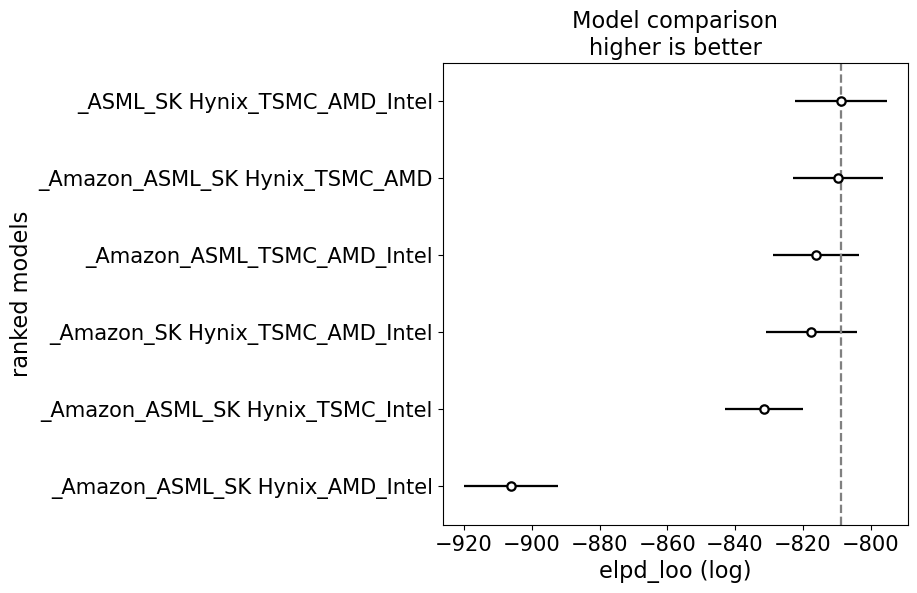

In [29]:
cmp_df_combinations = az.compare(idata_models)
az.plot_compare(cmp_df_combinations);

Thats crazy (not really). It turns out that the intersection of the top two from the 4 input combined to make the best 5 input.

Now we will finally compare to the best of the models that we have and see if there is any improvement.

In [30]:
priors_f1 = {
         "AMD" : bmb.Prior("Normal", mu=0,sigma=10),
         "ASML" : bmb.Prior("Normal", mu=0,sigma=10),
         "SK Hynix" : bmb.Prior("Normal", mu=0,sigma=10),
         "TSMC" : bmb.Prior("Normal", mu=0,sigma=10),"alpha" : bmb.Prior("HalfNormal",sigma=10)}

model_stock_f1 = bmb.Model("Nvidia ~ AMD + ASML + `SK Hynix` + TSMC", stockData_unified_cleaned, family = "gaussian", priors=priors_f1)
model_stock_f1.build()
idata_stock_f1 = model_stock_f1.fit(idata_kwargs={"log_likelihood":True})

Output()

In [32]:
priors_f2 = {
         "AMD" : bmb.Prior("Normal", mu=0,sigma=10),
         "Intel" : bmb.Prior("Normal", mu=0,sigma=10),
         "ASML" : bmb.Prior("Normal", mu=0,sigma=10),
         "SK Hynix" : bmb.Prior("Normal", mu=0,sigma=10),
         "TSMC" : bmb.Prior("Normal", mu=0,sigma=10),"alpha" : bmb.Prior("HalfNormal",sigma=10)}

model_stock_f2 = bmb.Model("Nvidia ~ AMD + ASML + `SK Hynix` + TSMC + Intel", stockData_unified_cleaned, family = "gaussian", priors=priors_f2)
model_stock_f2.build()
idata_stock_f2 = model_stock_f2.fit(idata_kwargs={"log_likelihood":True})

Output()

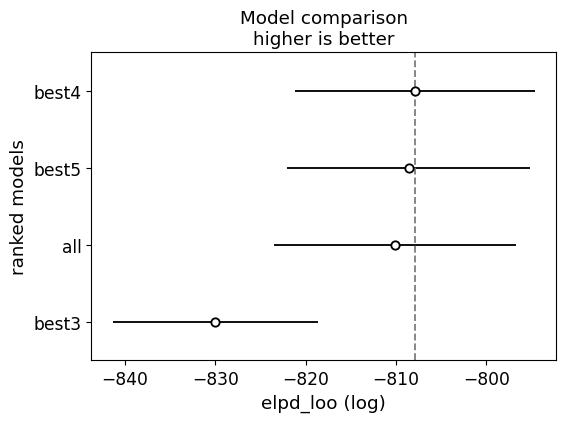

In [34]:
cmp_df_f = az.compare({"all":idata_stock_all,
                     "best4":idata_stock_f1,
                     "best5":idata_stock_f2,
                     "best3":idata_stock_ss2} )
az.plot_compare(cmp_df_f);

Ok this is pretty clear. It seems that the best 5,4,6 all do very similarly and even the best 3 are fairly close. Now I want to see if S&P and VIX will have any improvement on these.

In [35]:
columns_for_unified_cleaning = ['Nvidia', 'Amazon', 'AMD', 'ASML', 'SK Hynix', 'Intel', 'TSMC', 'VIX', 'S&P500']
stockData_unified_cleaned = stockData.dropna(subset=columns_for_unified_cleaning)

In [38]:
priors_ff1 = {
         "AMD" : bmb.Prior("Normal", mu=0,sigma=10),
         "S&P500" : bmb.Prior("Normal", mu=0,sigma=10),
         "VIX" : bmb.Prior("Normal", mu=0,sigma=10),
         "ASML" : bmb.Prior("Normal", mu=0,sigma=10),
         "SK Hynix" : bmb.Prior("Normal", mu=0,sigma=10),
         "TSMC" : bmb.Prior("Normal", mu=0,sigma=10),
         "alpha" : bmb.Prior("HalfNormal",sigma=10)}

model_stock_ff1 = bmb.Model("Nvidia ~ AMD + ASML + `SK Hynix` + TSMC + `S&P500` + VIX", stockData_unified_cleaned, family = "gaussian", priors=priors_ff1)
model_stock_ff1.build()
idata_stock_ff1 = model_stock_ff1.fit(idata_kwargs={"log_likelihood":True})

Output()

In [40]:
priors_ff2 = {
         "AMD" : bmb.Prior("Normal", mu=0,sigma=10),
         "VIX" : bmb.Prior("Normal", mu=0,sigma=10),
         "ASML" : bmb.Prior("Normal", mu=0,sigma=10),
         "SK Hynix" : bmb.Prior("Normal", mu=0,sigma=10),
         "TSMC" : bmb.Prior("Normal", mu=0,sigma=10),
         "alpha" : bmb.Prior("HalfNormal",sigma=10)}

model_stock_ff2 = bmb.Model("Nvidia ~ AMD + ASML + `SK Hynix` + TSMC + VIX", stockData_unified_cleaned, family = "gaussian", priors=priors_ff2)
model_stock_ff2.build()
idata_stock_ff2 = model_stock_ff2.fit(idata_kwargs={"log_likelihood":True})

Output()

In [41]:
priors_ff3 = {
         "AMD" : bmb.Prior("Normal", mu=0,sigma=10),
         "S&P500" : bmb.Prior("Normal", mu=0,sigma=10),
         "ASML" : bmb.Prior("Normal", mu=0,sigma=10),
         "SK Hynix" : bmb.Prior("Normal", mu=0,sigma=10),
         "TSMC" : bmb.Prior("Normal", mu=0,sigma=10),
         "alpha" : bmb.Prior("HalfNormal",sigma=10)}

model_stock_ff3 = bmb.Model("Nvidia ~ AMD + ASML + `SK Hynix` + TSMC + `S&P500`", stockData_unified_cleaned, family = "gaussian", priors=priors_ff3)
model_stock_ff3.build()
idata_stock_ff3 = model_stock_ff3.fit(idata_kwargs={"log_likelihood":True})

Output()

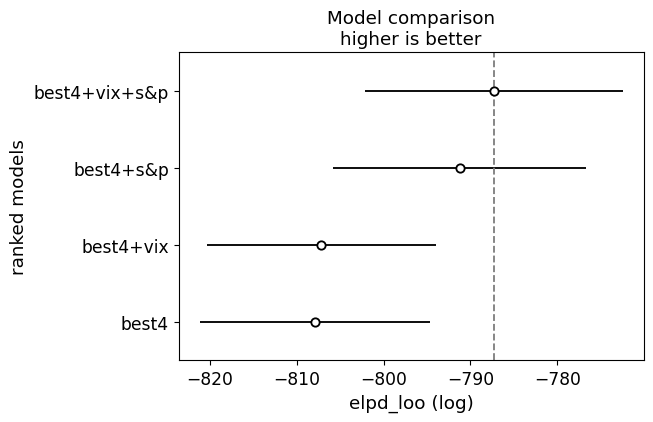

In [42]:
cmp_df_f = az.compare({"best4":idata_stock_f1,
                       "best4+vix+s&p":idata_stock_ff1,
                       "best4+vix":idata_stock_ff2,
                       "best4+s&p":idata_stock_ff3} )
az.plot_compare(cmp_df_f);

Well that seems to be a pretty conclusive answer. My best set of priors that I was able to make was AMD, S&P500, VIX, SK Hynix, TSMC, and ASML. I think that this makes a lot of sense now that I look back at it but still has a couple suprising parts. First, I think the inclusion of ASML, SK Hynix, and TSMC as the three most important stocks makes very clear sense as these are the companies that produce all of the tools and chips that Nvidia relies on. Additionally, in the most recent years, AMD has been much more of a competitor with Nvidia so it makes sense that is edges out Intel. Additionally, the fact that Intel ran into many struggles led their stock price to be a little more spuratic than usual so its predicting abilties seem to have taken a hit from that. The part that supprises me is the inclusion of the S&P500. That is because the S&P500 is so spread out over many fields including other areas of tech, oil, and medicine. Finally I was not too supriesd at the improvement from VIX.